In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from ast import arg
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

def fit(xs, y, optim_f, init_grid, top_k=500, n_proc=8, tol=None, disp=False, maxiter=None):
        _, _, brute_xs, brute_ys = scipy.optimize.brute(optim_f, init_grid, args=(xs, y), full_output=True, finish=None, Ns=1, workers=-1)

        brute_xs = brute_xs.reshape(brute_xs.shape[0], -1)
        brute_ys = brute_ys.reshape(-1)

        top_idxs = np.argsort(brute_ys)[:top_k]
        top_xs = brute_xs[:, top_idxs]
        # top_ys = brute_ys[top_idxs]
        preds = []
        for i in tqdm(range(top_xs.shape[1])):
            options = {'disp': disp}
            if maxiter: options['maxiter'] = maxiter
            pred = scipy.optimize.minimize(optim_f, top_xs[:, i], args=(xs, y), method='L-BFGS-B', tol=tol, options=options).x
            loss = optim_f(pred, xs, y)
            # print(pred, loss)
            preds.append((pred, loss))
        return sorted(preds, key=lambda x: x[1])[0][0]

def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    # return ((power_law_with_const(x,a,b,c) - y) ** 2).mean()
    with np.errstate(invalid='ignore', divide='ignore'):
        return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()

def power_law_with_const(x, a, b, c): return c * (1 + (x/b)**(-a))


100%|██████████| 125/125 [00:01<00:00, 117.25it/s]


loss 0.005570168965138759


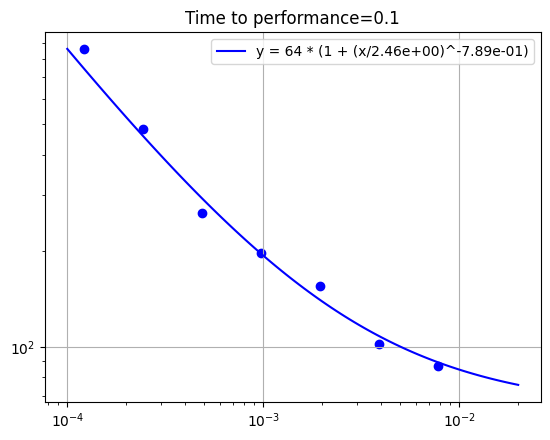

In [37]:
# Pareto fit 

n_parallel = np.array([1024, 2048, 4096, 8192, 16384, 32768, 65536])
utd = 1/n_parallel * 8
time_to_01 = np.array([87, 102, 155, 196, 262, 483, 860])
fit_data_points = [1, 2, 3, 4, 5]
plot_data_points = [0, 1, 2, 3, 4, 5, 6]

scaling = [1000, 1]
fitted_params = fit(utd[fit_data_points] * scaling[0], time_to_01[fit_data_points] * scaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', power_law_with_const_min(fitted_params, utd[fit_data_points] * scaling[0], time_to_01[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 1.3, 100)
y_fitted = power_law_with_const(x_smooth, a, b, c)
  
plt.title('Time to performance=0.1')
plt.scatter(utd[plot_data_points], time_to_01[plot_data_points], color='blue')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.0f} * (1 + (x/{b:.2e})^-{a:.2e})')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = power_law_with_const(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=131072: {get_lr(131072):.2e}')
print(f'Predicted learning rate for n_parallel=65536: {get_lr(65536):.2e}')
print(f'Predicted learning rate for n_parallel=32768: {get_lr(32768):.2e}')


Predicted learning rate for n_parallel=131072: 3.78e-04
Predicted learning rate for n_parallel=65536: 3.18e-04
Predicted learning rate for n_parallel=32768: 2.67e-04


100%|██████████| 125/125 [00:01<00:00, 116.75it/s]


loss 0.005570168965138759


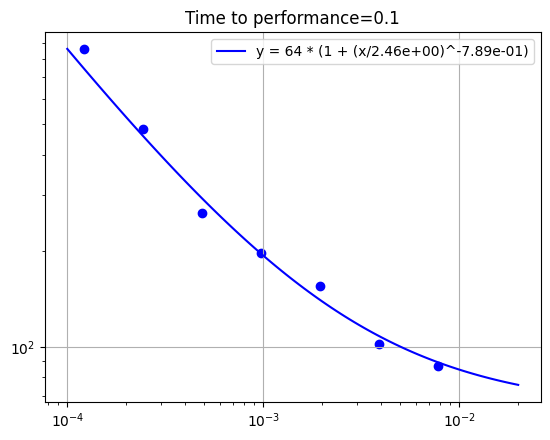

In [9]:
# Pareto - Optimal cost 

n_parallel = np.array([1024, 2048, 4096, 8192, 16384, 32768, 65536])
utd = 1/n_parallel * 8
time_to_01 = np.array([87, 102, 155, 196, 262, 483, 860])
fit_data_points = [1, 2, 3, 4, 5]
plot_data_points = [0, 1, 2, 3, 4, 5, 6]

scaling = [1000, 1]
fitted_params = fit(utd[fit_data_points] * scaling[0], time_to_01[fit_data_points] * scaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', power_law_with_const_min(fitted_params, utd[fit_data_points] * scaling[0], time_to_01[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 1.3, 100)
y_fitted = power_law_with_const(x_smooth, a, b, c)
  
plt.title('Time to performance=0.1')
plt.scatter(utd[plot_data_points], time_to_01[plot_data_points], color='blue')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.0f} * (1 + (x/{b:.2e})^-{a:.2e})')

# plot cost line: the cost of each point is y * 1e6 + y * x 
# plt.plot(x_smooth / scaling[0], y_fitted / scaling[1] * 1e6 + y_fitted / scaling[1] * x_smooth / scaling[0], 'r-', label='Cost line')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

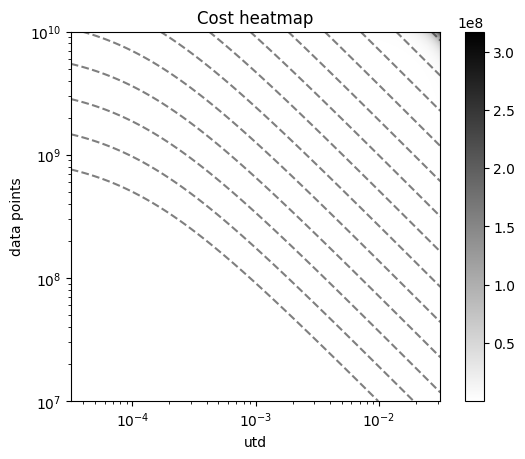

In [45]:
# plot a cost heatmap with toy data 

x = np.logspace(-4.5, -1.5, 100) # utd
y = np.logspace(7, 10, 100)      # data points
utd, data_points = np.meshgrid(x, y)
# rl update time: 13 fps, step inference time: 1e5 fps
c = 1e-4 # cost of data relative to cost of gradient step
cost = data_points * c + data_points * utd
plt.imshow(cost, cmap='binary', interpolation='bilinear', origin='lower', 
           extent=[x.min(), x.max(), 
                  y.min(), y.max()])
plt.colorbar()

# plot lines of iso cost
plt.contour(utd, data_points, cost, levels=np.logspace(5, 9, 15), colors='black', alpha=0.5, linestyles='dashed')

plt.title('Cost heatmap')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('utd')
plt.ylabel('data points')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


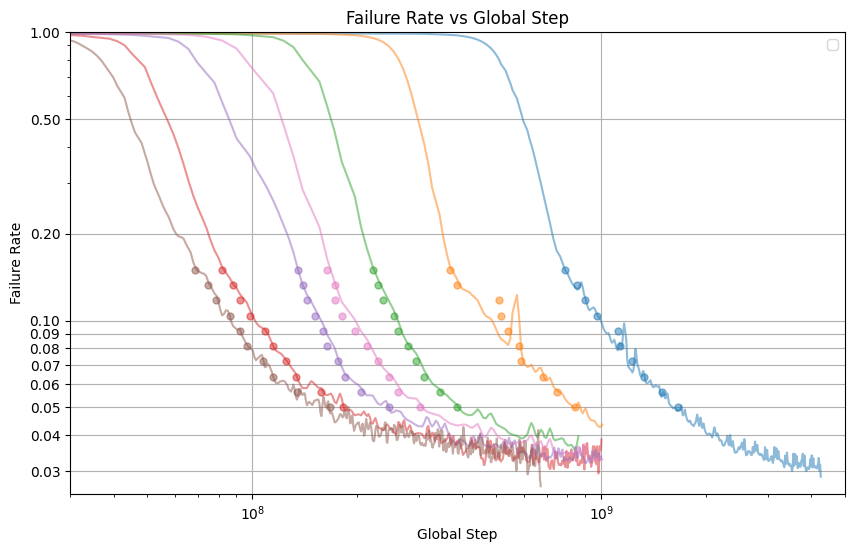

In [4]:
# All pareto fronts

from scipy.ndimage import gaussian_filter1d

data = pd.read_csv('data/igpush_best.csv')

data.filter(regex='failure_2_last$|global_step')

# Plot data against global_step
plt.figure(figsize=(10, 6))

# Define a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Get all columns except global_step for plotting
failure_cols = data.filter(regex='failure_2_last$').columns
# remove noisy data
# failure_cols = [col for col in failure_cols if col != 'experiment: hlg_1cubes_b32768_mb5120_lr2.5e-4 - episodic_stats/failure_2_last']
# failure_cols = [col for col in failure_cols if col != 'experiment: hlg_1cubes_b65536_mb8064_lr3.7e-4 - episodic_stats/failure_2_last']
time_to_x = [0.05, 0.1, 0.23, 0.5]
time_to_x = np.logspace(np.log10(0.05), np.log10(0.5), 6)
time_to_x = np.logspace(np.log10(0.05), np.log10(0.15), 6)
time_to_x = np.logspace(np.log10(0.05), np.log10(0.5), 20)
time_to_x = np.logspace(np.log10(0.05), np.log10(0.15), 10)

# Store crossings for each curve and target rate
all_crossings = {}

# column names look like this: experiment: hlg_1cubes_b65536_mb8064_lr3.7e-4 - _step
for i, col in enumerate(failure_cols):
    x = data['global_step'][data[col].notna()]
    y = data[col][data[col].notna()]
    y = gaussian_filter1d(y, sigma=1)
    y_smooth = y
    plt.plot(x, y_smooth, color=colors[i % len(colors)], alpha=0.5, markersize=5)
    
    all_crossings[col] = {}
    
    for rate in time_to_x:
        # Find where curve crosses the target rate
        crossings = np.mean(np.where(np.diff(np.signbit(y - rate))), axis=1).astype(int)
        all_crossings[col][rate] = []
        
        if len(crossings) > 0:
            # Get the x,y coordinates of intersection
            for idx in crossings:
                x_cross = x.iloc[idx]
                y_cross = y[idx]
                all_crossings[col][rate] = x_cross
                plt.plot(x_cross, rate, 'o', color=colors[i % len(colors)], alpha=0.5, markersize=5)

plt.xlabel('Global Step')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs Global Step')
plt.xlim(3e7, 5e9)
plt.ylim(0.025, 1)
plt.xscale('log')
plt.yscale('log')
yticks = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5, 1]
plt.yticks(yticks, [f'{y:.2f}' for y in yticks])
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 1024  2048  4096  8192 16384 32768 65536]


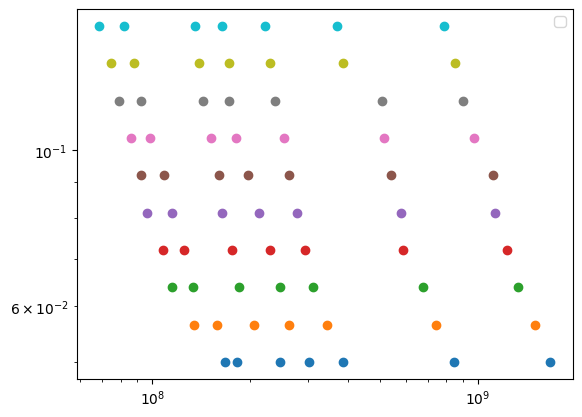

In [5]:
# Make crossings an array of shape (n_batch_sizes, n_targets)

batch_sizes = np.array(sorted([int(col.split('_b')[1].split('_')[0]) for col in failure_cols]))
print(batch_sizes)

# make crossings an array
np_crossings = dict((x,np.array(list(y.values()))) for x,y in all_crossings.items()) # remove dict
np_crossings = dict((int(x.split('_b')[1].split('_')[0]),y) for x,y in np_crossings.items()) # get batch size
np_crossings = np.array([np_crossings[batch_size] for batch_size in batch_sizes])

# plot crossings
for j, target in enumerate(time_to_x):
    plt.scatter(np_crossings[:,j], [target] * len(np_crossings[:,j]))

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


100%|██████████| 27/27 [00:00<00:00, 130.95it/s]

time to 0.049999999999999996: 17 * (1 + (x/7.20e-01)^-1.21e+00)



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
100%|██████████| 27/27 [00:00<00:00, 120.71it/s]

time to 0.05649154819548764: 14 * (1 + (x/8.35e-01)^-1.18e+00)



100%|██████████| 27/27 [00:00<00:00, 132.81it/s]

time to 0.06382590035046207: 11 * (1 + (x/1.05e+00)^-1.10e+00)



100%|██████████| 27/27 [00:00<00:00, 143.39it/s]

time to 0.0721124785153704: 10 * (1 + (x/1.08e+00)^-1.08e+00)



100%|██████████| 27/27 [00:00<00:00, 139.11it/s]

time to 0.08147491111094231: 9 * (1 + (x/1.23e+00)^-1.04e+00)



100%|██████████| 27/27 [00:00<00:00, 143.48it/s]

time to 0.09205287735493739: 9 * (1 + (x/1.11e+00)^-1.09e+00)



100%|██████████| 27/27 [00:00<00:00, 148.91it/s]

time to 0.10400419115259521: 8 * (1 + (x/1.28e+00)^-1.02e+00)



100%|██████████| 27/27 [00:00<00:00, 144.58it/s]

time to 0.11750715554059085: 7 * (1 + (x/1.43e+00)^-9.87e-01)



100%|██████████| 27/27 [00:00<00:00, 143.75it/s]

time to 0.13276322281071903: 6 * (1 + (x/1.70e+00)^-9.40e-01)



100%|██████████| 27/27 [00:00<00:00, 141.75it/s]


time to 0.15: 5 * (1 + (x/2.18e+00)^-8.86e-01)


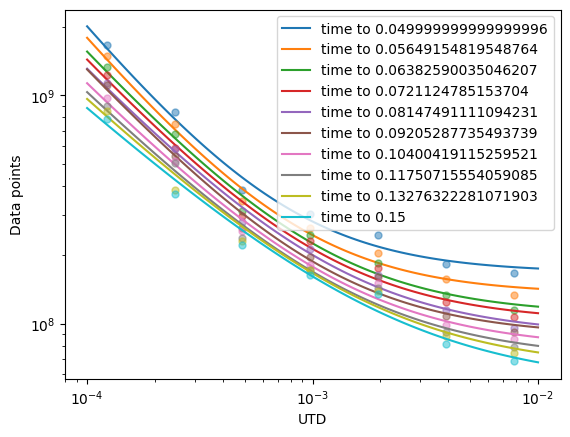

In [6]:
# Plot pareto front

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']
fits = []
for j, target in enumerate(time_to_x):
    x = 1/batch_sizes * 8
    y = np_crossings[:,j]

    # fit power law using fit()
    fit_data_points = [0, 1, 2, 3, 4, 5, 6]
    fit_data_points = [0, 1, 2, 3, 4, 6]
    scaling = [1000, 1e-7]
    fitted_params = fit(x[fit_data_points] * scaling[0], y[fit_data_points] * scaling[1], power_law_with_const_min, [slice(-4, 4, 3.2),slice(1e-5, 5e-4, 2e-4),slice(-10, 10, 8)], maxiter=100)
    a, b, c = fitted_params
    fits.append((a, b, c))
    
    x_smooth = np.logspace(-1, 1, 100)
    y_fitted = power_law_with_const(x_smooth, a, b, c)

    plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'r-', label=f'time to {target}', color=colors[j])
    print(f'time to {target}: {c:.0f} * (1 + (x/{b:.2e})^-{a:.2e})')
    plt.plot(x, y, 'o', color=colors[j], alpha=0.5, markersize=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('UTD')
plt.ylabel('Data points')
plt.legend()
plt.show()


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  


Minimum cost point for 0.049999999999999996: UTD=2.60e+00, data=2.03e+01, cost=2.56e+06
Minimum cost point for 0.05649154819548764: UTD=2.85e+00, data=1.67e+01, cost=2.14e+06
Minimum cost point for 0.06382590035046207: UTD=3.27e+00, data=1.41e+01, cost=1.87e+06
Minimum cost point for 0.0721124785153704: UTD=3.27e+00, data=1.33e+01, cost=1.76e+06
Minimum cost point for 0.08147491111094231: UTD=3.59e+00, data=1.19e+01, cost=1.61e+06
Minimum cost point for 0.09205287735493739: UTD=3.43e+00, data=1.14e+01, cost=1.53e+06
Minimum cost point for 0.10400419115259521: UTD=3.59e+00, data=1.05e+01, cost=1.43e+06
Minimum cost point for 0.11750715554059085: UTD=3.76e+00, data=9.66e+00, cost=1.33e+06
Minimum cost point for 0.13276322281071903: UTD=4.13e+00, data=9.03e+00, cost=1.28e+06
Minimum cost point for 0.15: UTD=4.53e+00, data=8.20e+00, cost=1.19e+06


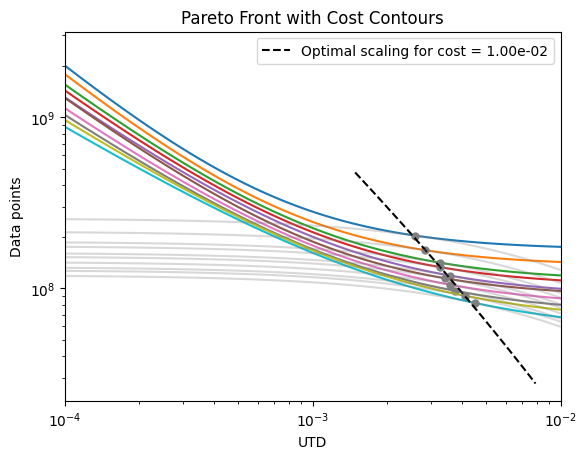

In [31]:
# plot fits with contours

# plot cost contours
data_cost = 1e-4 # cost of data relative to cost of gradient step
data_cost = 2e-4 # cost of data relative to cost of gradient step
data_cost = 1e-3 # cost of data relative to cost of gradient step
data_cost = 1e-2 # cost of data relative to cost of gradient step
# Add cost contours to previous plot

# plot fits and save minimum cost points
min_cost_points_utd = []
min_cost_points_data = []
for j, target in enumerate(time_to_x):
    x = np.logspace(-1, 1, 100)
    y = power_law_with_const(x, *fits[j])
    plt.plot(x / scaling[0], y / scaling[1], 'r-', color=colors[j])

    # Calculate cost at each point
    cost_fn = lambda x, y: x * y + y * data_cost
    costs = cost_fn(x / scaling[0], y / scaling[1])
    min_cost_idx = np.argmin(costs)
    
    # Plot minimum cost point
    plt.plot(x[min_cost_idx] / scaling[0], y[min_cost_idx] / scaling[1], 'o', color='gray', markersize=5)
    print(f'Minimum cost point for {target}: UTD={x[min_cost_idx]:.2e}, data={y[min_cost_idx]:.2e}, cost={costs[min_cost_idx]:.2e}')
    
    min_cost_points_utd.append(x[min_cost_idx] / scaling[0])
    min_cost_points_data.append(y[min_cost_idx] / scaling[1])

# fit line of x given cost
min_cost_points_utd = np.array(min_cost_points_utd)
min_cost_points_data = np.array(min_cost_points_data)
min_cost_points_cost = cost_fn(min_cost_points_utd, min_cost_points_data)
# fit line of cost given log x
a,b = np.polyfit(np.log10(min_cost_points_utd), np.log10(min_cost_points_cost), 1)

# For each x, calculate predicted cost and solve for y
xmin, xmax = np.log10(min_cost_points_utd.min()), np.log10(min_cost_points_utd.max())
xmin, xmax = xmin - xmax + xmin, xmax - xmin + xmax
x_plot = np.logspace(xmin, xmax, 100)
# x_plot = np.logspace(-3, -2.2, 100)
predicted_cost = 10**(a*np.log10(x_plot) + b)
# cost = data * (x + c)  --> data = cost/(x + c)
y_plot = predicted_cost/(x_plot + data_cost)

plt.plot(x_plot, y_plot, '--k', label=f'Optimal scaling for cost = {data_cost:.2e}')


# # Fit line of y given x
# a_y,b_y = np.polyfit(np.log10(min_cost_points_utd), np.log10(min_cost_points_data), 1)

# # Calculate predicted y values
# x_plot_y = np.logspace(np.log10(1e-4), np.log10(1e-2), 100)
# y_plot_y = 10**(a_y*np.log10(x_plot_y) + b_y)

# plt.plot(x_plot_y, y_plot_y, '--r', label='Direct y scaling')


# plot cost contours
x = np.logspace(-4, -2, 100)
y = np.logspace(7.5, 9.5, 100)
utd, data_points = np.meshgrid(x, y)

# Cost = UTD * data points
cost = utd * data_points + data_points * data_cost
# plt.contour(utd, data_points, cost, levels=np.logspace(3, 8, 100), alpha=0.3, colors='gray')
plt.contour(utd, data_points, cost, levels=sorted(min_cost_points_cost), alpha=0.3, colors='gray')


plt.xscale('log')
plt.yscale('log')
# plt.xlim(0, 0.002)
# plt.ylim(1e8, 1e9)
plt.xlabel('UTD')
plt.ylabel('Data points')
plt.legend()
plt.title('Pareto Front with Cost Contours')
plt.show()



Text(0, 0.5, 'optimal UTD')

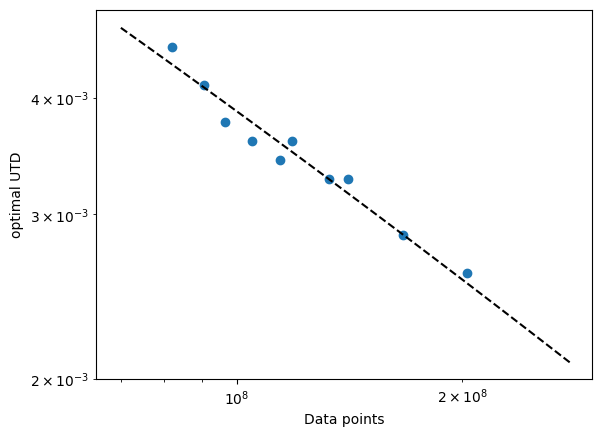

In [32]:
# plot optimal points: y vs x
plt.scatter(min_cost_points_data, min_cost_points_utd)
plt.plot(y_plot[20:-30], x_plot[20:-30], '--k', label=f'Optimal scaling for cost = {data_cost:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Data points')
plt.ylabel('optimal UTD')
# also plot the line

/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  del sys.path[0]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


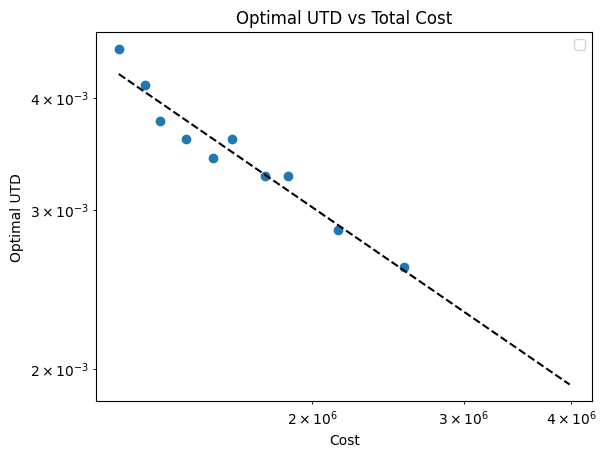

In [46]:
# Calculate costs for each point
costs = min_cost_points_utd * min_cost_points_data + min_cost_points_data * data_cost

# Fit a line to the log-transformed data
log_costs = np.log10(costs)
log_utd = np.log10(min_cost_points_utd)
a, b = np.polyfit(log_costs, log_utd, 1)

# Generate points for the fitted line
x_fit = np.logspace(min(log_costs), max(log_costs) * 1.03, 100)
y_fit = 10**(a * np.log10(x_fit) + b)

plt.plot(x_fit, y_fit, 'r--', color='black')
plt.scatter(costs, min_cost_points_utd)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cost')
plt.ylabel('Optimal UTD')
plt.legend()
plt.title('Optimal UTD vs Total Cost')
plt.grid(True)
plt.show()


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  


Minimum cost point for 0.049999999999999996 (data_cost=1.00e-05): UTD=2.42e-01, data=7.97e+01, cost=2.01e+05
Minimum cost point for 0.05649154819548764 (data_cost=1.00e-05): UTD=2.42e-01, data=7.17e+01, cost=1.81e+05
Minimum cost point for 0.06382590035046207 (data_cost=1.00e-05): UTD=1.92e-01, data=8.16e+01, cost=1.65e+05
Minimum cost point for 0.0721124785153704 (data_cost=1.00e-05): UTD=1.75e-01, data=8.31e+01, cost=1.54e+05
Minimum cost point for 0.08147491111094231 (data_cost=1.00e-05): UTD=1.52e-01, data=8.77e+01, cost=1.42e+05
Minimum cost point for 0.09205287735493739 (data_cost=1.00e-05): UTD=1.83e-01, data=7.15e+01, cost=1.38e+05
Minimum cost point for 0.10400419115259521 (data_cost=1.00e-05): UTD=1.32e-01, data=8.69e+01, cost=1.24e+05
Minimum cost point for 0.11750715554059085 (data_cost=1.00e-05): UTD=1.10e-01, data=9.48e+01, cost=1.14e+05
Minimum cost point for 0.13276322281071903 (data_cost=1.00e-05): UTD=1.00e-01, data=9.64e+01, cost=1.06e+05
Minimum cost point for 0.15 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Minimum cost point for 0.049999999999999996 (data_cost=1.62e-03): UTD=1.18e+00, data=2.60e+01, cost=7.28e+05
Minimum cost point for 0.05649154819548764 (data_cost=1.62e-03): UTD=1.29e+00, data=2.16e+01, cost=6.29e+05
Minimum cost point for 0.06382590035046207 (data_cost=1.62e-03): UTD=1.42e+00, data=1.88e+01, cost=5.72e+05
Minimum cost point for 0.0721124785153704 (data_cost=1.62e-03): UTD=1.42e+00, data=1.78e+01, cost=5.41e+05
Minimum cost point for 0.08147491111094231 (data_cost=1.62e-03): UTD=1.48e+00, data=1.63e+01, cost=5.06e+05
Minimum cost point for 0.09205287735493739 (data_cost=1.62e-03): UTD=1.42e+00, data=1.56e+01, cost=4.75e+05
Minimum cost point for 0.10400419115259521 (data_cost=1.62e-03): UTD=1.48e+00, data=1.45e+01, cost=4.49e+05
Minimum cost point for 0.11750715554059085 (data_cost=1.62e-03): UTD=1.48e+00, data=1.37e+01, cost=4.26e+05
Minimum cost point for 0.13276322281071903 (data_cost=1.62e-03): UTD=1.56e+00, data=1.31e+01, cost=4.18e+05
Minimum cost point for 0.15 

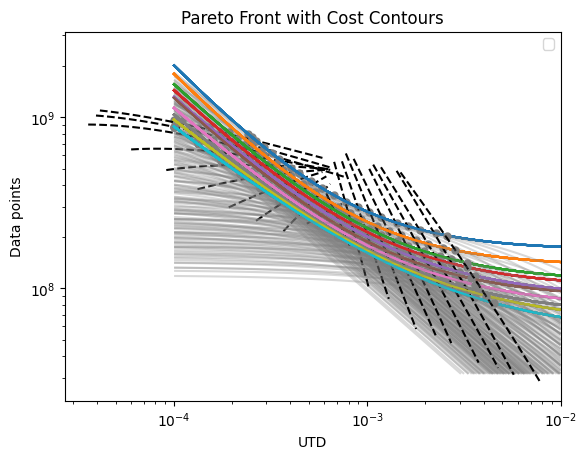

In [56]:
# plot fits with contours

# Define range of data costs
data_costs = np.logspace(-5, -2, 20)  # 10 points between 1e-4 and 1e-2

# plot fits and save minimum cost points for each data cost
for data_cost in data_costs:
    min_cost_points_utd = []
    min_cost_points_data = []
    
    for j, target in enumerate(time_to_x):
        x = np.logspace(-1, 1, 100)
        y = power_law_with_const(x, *fits[j])
        plt.plot(x / scaling[0], y / scaling[1], 'r-', color=colors[j])

        # Calculate cost at each point
        cost_fn = lambda x, y: x * y + y * data_cost
        costs = cost_fn(x / scaling[0], y / scaling[1])
        min_cost_idx = np.argmin(costs)
        
        # Plot minimum cost point
        plt.plot(x[min_cost_idx] / scaling[0], y[min_cost_idx] / scaling[1], 'o', color='gray', markersize=5)
        print(f'Minimum cost point for {target} (data_cost={data_cost:.2e}): UTD={x[min_cost_idx]:.2e}, data={y[min_cost_idx]:.2e}, cost={costs[min_cost_idx]:.2e}')
        
        min_cost_points_utd.append(x[min_cost_idx] / scaling[0])
        min_cost_points_data.append(y[min_cost_idx] / scaling[1])

    min_cost_points_utd = np.array(min_cost_points_utd)
    min_cost_points_data = np.array(min_cost_points_data)
    min_cost_points_cost = cost_fn(min_cost_points_utd, min_cost_points_data)
    
    # fit line of cost given log x
    a,b = np.polyfit(np.log10(min_cost_points_utd), np.log10(min_cost_points_cost), 1)

    # For each x, calculate predicted cost and solve for y
    xmin, xmax = np.log10(min_cost_points_utd.min()), np.log10(min_cost_points_utd.max())
    xmin, xmax = xmin + 1*(- xmax + xmin), xmax + 1*(- xmin + xmax)
    x_plot = np.logspace(xmin, xmax, 100)
    predicted_cost = 10**(a*np.log10(x_plot) + b)
    y_plot = predicted_cost/(x_plot + data_cost)

    plt.plot(x_plot, y_plot, '--k')

    # plot cost contours
    x = np.logspace(-4, -2, 100)
    y = np.logspace(7.5, 9.5, 100)
    utd, data_points = np.meshgrid(x, y)

    # Cost = UTD * data points + data points * data_cost
    cost = utd * data_points + data_points * data_cost
    plt.contour(utd, data_points, cost, levels=sorted(min_cost_points_cost), alpha=0.3, colors='gray')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('UTD')
plt.ylabel('Data points')
plt.legend()
plt.title('Pareto Front with Cost Contours')
plt.show()
